In [ ]:
from pathlib import Path
import os
os.environ["DATA"] = "/content/drive/MyDrive/IMT/Internship"
# db_dir = os.environ["DATA"] + "PatImgXAI_data/db0.1.5/"
db_dir = os.environ["DATA"] + "PatImgXAI_data/db.vlm/" #(6000  train datasets , 600 test, 600 valid) for one rule
db = os.path.join(db_dir, "datasets")
model_dir = os.environ["DATA"] + "models/db.vlm/qwen2.5-vl"

In [ ]:
!pip install  -U -q git+https://github.com/huggingface/transformers.git git+https://github.com/huggingface/trl.git datasets bitsandbytes peft qwen-vl-utils wandb accelerate
# Tested with transformers==4.53.0.dev0, trl==0.20.0.dev0, datasets==3.6.0, bitsandbytes==0.46.0, peft==0.15.2, qwen-vl-utils==0.0.11, wandb==0.20.1, accelerate==1.8.1

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.9/504.9 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 38.6 MB/s eta 0:00:00


In [ ]:
!pip install -q torch==2.4.1+cu121 torchvision==0.19.1+cu121 torchaudio==2.4.1+cu121 --extra-index-url https://download.pytorch.org/whl/cu121

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.9/798.9 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 121.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 108.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 104.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 116.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

Prepare dataset 
This dataset contains images paired with related rule questions and explanations.
 The file must be in the JSON Lines format, meaning each line is a separate, valid JSON object.
   * Each JSON object must contain two keys:
       1. "image_path": The path of the image .
       2. "explanation": The perfect, ground-truth output you want the model to generate for that image. This
          is what the model will learn from.

In [ ]:
system_message = """You are a Vision Language Model specialized in analyzing images containing colored shapes on a 6x6 grid labeled A–F (columns) and 1–6 (rows).
Follow the RULE in the user message exactly.

Respond in EXACTLY two tagged sections and in THIS order:
-“only X” → zero non-X within the stated scope; empty cells are ignored (one X + the rest empty still qualifies).
- “at least / exactly / at most N” → ≥ / == / ≤.
- Comparatives (e.g., “twice as many X as Y”) refer to counts of shapes matching those filters.
<|human|>
- Answer: 'This respect the rule' or 'This does not respect the rule'.
- Then explain: counts by shape/color and positions used to decide. Empty cells never count or break rules.

<|system|>
In THIS section return **only** a valid JSON object (no extra text) with exactly these keys:
{
  "relevant_positions":   ["A6"],
  "irrelevant_positions": ["A2","A4",…],
  "relevant_shapes":      ["circle"],
  "irrelevant_shapes":    ["triangle","triangle",…],
  "relevant_colors":      ["blue"],
  "irrelevant_colors":    ["green","blue",…]
}
- Return **only** a valid JSON object in THIS section. **Stop immediately after the closing `}`. Do not output anything else.**
- Coverage: `relevant_*` + `irrelevant_*` must enumerate **all shapes in the entire grid** (empty cells ignored).
- Arrays are **index-aligned**: positions[i] ↔ shapes[i] ↔ colors[i].
- Total shapes ≤ 36. No duplicates.

"""


We’ll format the dataset into a chatbot structure for interaction. Each interaction will consist of a system message, followed by the image and the user's query, and finally, the answer to the query

In [ ]:
from PIL import Image
import os
import json

def format_data(sample, rule_prompt):
    # Construct the full path to the image file
    image_path = os.path.join(db_dir, sample["path"])
    return [
        {"role": "system", "content": [{"type": "text", "text": system_message}]},
        {"role": "user", "content": [
            {"type": "image", "image": image_path},
            {"type": "text", "text": rule_prompt}
        ]},
        {"role": "assistant", "content": [
            {"type": "text", "text":
                "<|human|>"  + sample["explanation"]["human"] + "\n" +
                "<|system|>" + json.dumps(sample["explanation"]["system"], separators=(',',':'))}
        ]}
    ]

Define file-to-rule mapping since our dataset does not contained image paired with related question so we need to define the questions

In [ ]:
#file rule map function just store a text description of the rule (for static rule), for complex rule like red in row 2 because the rule depend on the image context
file_rule_map = {
    "onlycircle_train_explanations.json": "Does this image has at least one row that contains only circles?",
    "red_in_row_2_train_explanations.json": "If row 2 (index 1) contains a red symbol, does the image contain at least as many triangles as blue symbols? Otherwise, does the image contain at least as many green symbols as squares?",
}

def get_red_in_row_2_rule(sample):
    """
    This function checks if a red symbol is in row 2 and returns the appropriate rule.
    """
    relevant_positions = sample["explanation"]["system"]["relevant_positions"]
    irrelevant_positions = sample["explanation"]["system"]["irrelevant_positions"]
    relevant_colors = sample["explanation"]["system"]["relevant_colors"]
    irrelevant_colors = sample["explanation"]["system"]["irrelevant_colors"]

    # Combine relevant and irrelevant data for easier iteration
    all_positions = relevant_positions + irrelevant_positions
    all_colors = relevant_colors + irrelevant_colors

    has_red_in_row_2 = False
    for i in range(len(all_positions)):
        position = all_positions[i]
        color = all_colors[i]

        # Check if the position is in row 2 (contains '2') and the color is 'red'
        if '2' in position and color == 'red':
            has_red_in_row_2 = True
            break # Found a red symbol in row 2, no need to check further

    if has_red_in_row_2:
        return "Does the image contain at least as many triangles as blue symbols?"
    else:
        return "Does the image contain at least as many green symbols as squares?"


def get_rule_prompt(filename, sample=None):
    """
    Get the rule prompt for a given filename.
    :param filename: The name of the dataset file
    :param sample: The data sample, required for conditional rules.
    :return: The corresponding rule prompt.
    """
    # takes a filename and and replace any file with _valid or _train extension at the end with _train in order to get the rule prompt for that filename
    basename = os.path.basename(filename)
    lookup_name = basename.replace("_valid_", "_train_").replace("_test_", "_train_")

    if lookup_name == "red_in_row_2_train_explanations.json":
        if sample:
            return get_red_in_row_2_rule(sample)
        else:
            # Return a default or combined rule description if no sample is provided
            return file_rule_map[lookup_name]

    return file_rule_map[lookup_name]

Load dataset

In [ ]:
import json

train_files = [
    "onlycircle_train_explanations.json",
    "red_in_row_2_train_explanations.json"
]

valid_files = [
    "onlycircle_valid_explanations.json",
    "red_in_row_2_valid_explanations.json"
]

test_files = [
    "onlycircle_test_explanations.json",
    "red_in_row_2_test_explanations.json"
]

train_data_fullpath = [os.path.join(db, fname) for fname in train_files]
valid_data_fullpath = [os.path.join(db, fname) for fname in valid_files]
test_data_fullpath  = [os.path.join(db, fname) for fname in test_files]

#preprocess dataset
def process_files(file_list):
    all_formatted = []
    for file in file_list:
        with open(file, 'r') as f:
            samples = json.load(f)
            for sample in samples:
                rule_prompt = get_rule_prompt(file, sample)
                # Modify to return a list of dictionaries
                all_formatted.append({"messages": format_data(sample, rule_prompt)})
    return all_formatted

#format the dataset into a conversation structure
train_dataset = process_files(train_data_fullpath)
valid_dataset = process_files(valid_data_fullpath)
test_dataset = process_files(test_data_fullpath)

print("All datasets processed and saved!")

All datasets processed and saved!


In [ ]:
train_dataset[0]

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are a Vision Language Model specialized in analyzing images containing colored shapes on a 6x6 grid labeled A–F (columns) and 1–6 (rows).\nFollow the RULE in the user message exactly.\n\nRespond in EXACTLY two tagged sections and in THIS order:\n-“only X” → zero non-X within the stated scope; empty cells are ignored (one X + the rest empty still qualifies).\n- “at least / exactly / at most N” → ≥ / == / ≤.\n- Comparatives (e.g., “twice as many X as Y”) refer to counts of shapes matching those filters.\n<|human|>\n- Answer: \'This respect the rule\' or \'This does not respect the rule\'.\n- Then explain: counts by shape/color and positions used to decide. Empty cells never count or break rules.\n\n<|system|>\nIn THIS section return **only** a valid JSON object (no extra text) with exactly these keys:\n{\n  "relevant_positions":   ["A6"],\n  "irrelevant_positions": ["A2","A4",…],\n  "relevant_shapes":     

In [ ]:
from datasets import Dataset
train_dataset = Dataset.from_list(train_dataset)
valid_dataset = Dataset.from_list(valid_dataset)
test_dataset = Dataset.from_list(test_dataset)

In [ ]:
train_dataset

Dataset({
    features: ['messages'],
    num_rows: 9600
})

##Load Model

In [ ]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor

model_id = "Qwen/Qwen2.5-VL-7B-Instruct"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    attn_implementation="sdpa"
)
processor = AutoProcessor.from_pretrained(model_id)


`torch_dtype` is deprecated! Use `dtype` instead!
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json: 0.00B [00:00, ?B/s]

In [ ]:
train_dataset[0]["messages"][1]["content"][0]["image"]

'/content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db.vlm/img/252f617e7c0311f0bf0f0242ac1c000c.png'

Check to see if the image exist

In [ ]:
bad = []
for i in range(len(train_dataset)):
    msgs = train_dataset[i]["messages"]
    for turn in msgs:
        for blk in turn.get("content", []):
            if blk.get("type") == "image":
                img = blk.get("image")
                if img is None:
                    bad.append((i, "None"))
                elif isinstance(img, dict):
                    if not (img.get("path") or img.get("bytes")):
                        bad.append((i, "dict-without-path-or-bytes"))
                elif isinstance(img, str):
                    if not os.path.exists(img):
                        bad.append((i, f"path-missing:{img}"))
# inspect a few
bad[:5], len(bad)


([], 0)

In [ ]:
train_dataset[0]['messages'][1:2]

[{'content': [{'image': '/content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db.vlm/img/252f617e7c0311f0bf0f0242ac1c000c.png',
    'text': None,
    'type': 'image'},
   {'image': None,
    'text': 'Does this image has at least one row that contains only circles?',
    'type': 'text'}],
  'role': 'user'}]

### Function: `clean_turns`

This function takes a list of messages (representing a conversation turn) and cleans up the content. It filters out any content blocks that have a `None` value for either `image` or `text`, ensuring that only valid image or text blocks are included in the cleaned output. This is useful when working with datasets that might have placeholder `None` values for certain content types.

### Function: `only_image_blocks`

This function takes a list of messages and extracts only the image content blocks. It iterates through each message and its content, appending any block of type "image" with a non-`None` image value to a new list. This function is helpful for isolating and processing only the visual information within a conversation turn.

In [ ]:
# Datasets (hugging face) “rectangularizes” nested dicts, so text blocks often get image: None and image blocks get text: None.
def clean_turns(messages):
    cleaned = []
    for turn in messages:
        new_content = []
        for b in turn.get("content", []):
            if b.get("type") == "image" and b.get("image") is not None:
                new_content.append({"type":"image","image": b["image"]})
            elif b.get("type") == "text" and b.get("text") is not None:
                new_content.append({"type":"text","text": b["text"]})
        if new_content:
            cleaned.append({"role": turn["role"], "content": new_content})
    return cleaned

def only_image_blocks(messages):
    image_only = []
    for turn in messages:
        image_blocks = [b for b in turn.get("content", []) if b.get("type") == "image" and b.get("image") is not None]
        if image_blocks:
            image_only.append({"role": turn["role"], "content": image_blocks})
    return image_only


In [ ]:
from qwen_vl_utils import process_vision_info
from PIL import Image
import io

#model prediction
def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    messages = sample if isinstance(sample, list) else sample["messages"]
    #since we have strict instruction so include both the system + user prompt
    raw_ctx = [m for m in messages if m["role"] in ("system","user")][:2]
    ctx = clean_turns(raw_ctx)
    text_input = processor.apply_chat_template(
        ctx, tokenize=False, add_generation_prompt=True
    )

    # Process the visual input from the sample
    img_ctx = only_image_blocks(ctx)
    image_inputs, _ = process_vision_info(img_ctx)

    # Prepare the inputs for the model
    model_inputs = processor(
        text=[text_input],
        images=image_inputs,
        return_tensors="pt",
    ).to(device)

    # Generate text with the model
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        eos_token_id=processor.tokenizer.eos_token_id
    )

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

Because the model couldn't predict and explain accurately, this is the reason why we proceed to the finetunning process.

In [ ]:
output = generate_text_from_sample(model, processor, train_dataset[0])
output

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


'{\n  "relevant_positions": ["D6"],\n  "irrelevant_positions": ["A1", "B1", "C1", "D1", "E1", "F1", "A2", "B2", "C2", "D2", "E2", "F2", "A3", "B3", "C3", "D3", "E3", "F3", "A4", "B4", "C4", "D4", "E4", "F4", "A5", "B5", "C5", "D5", "E5", "F5", "A6", "B6"],\n  "relevant_shapes": ["circle"],\n  "irrelevant_shapes": ["triangle", "square"],\n  "relevant_colors": ["blue"],\n  "irrelevant_colors": ["red", "yellow"]\n}'

In [ ]:
import gc
import time


def clear_memory():
    # Delete variables if they exist in the current global scope
    if "inputs" in globals():
        del globals()["inputs"]
    if "model" in globals():
        del globals()["model"]
    if "processor" in globals():
        del globals()["processor"]
    if "trainer" in globals():
        del globals()["trainer"]
    if "peft_model" in globals():
        del globals()["peft_model"]
    if "bnb_config" in globals():
        del globals()["bnb_config"]
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


clear_memory()

GPU allocated memory: 0.01 GB
GPU reserved memory: 14.43 GB


##Finetune the model using TRL

In [ ]:
import torch
from transformers import BitsAndBytesConfig, Qwen2_5_VLForConditionalGeneration, AutoProcessor

bnb = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id, device_map="auto", quantization_config=bnb
)
processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

##Set Up QLoRA and SFTConfig

In [ ]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 2,523,136 || all params: 8,294,689,792 || trainable%: 0.0304


In [ ]:
from trl import SFTConfig

# Configure training arguments
training_args = SFTConfig(
    # output_dir="qwen2.5-7b-instruct-trl-sft-ChartQA",
    output_dir=model_dir,# Directory to save the model
    num_train_epochs=1,  # Number of training epochs
    per_device_train_batch_size=4,  # Batch size for training
    per_device_eval_batch_size=4,  # Batch size for evaluation
    gradient_accumulation_steps=8,  # Steps to accumulate gradients
    gradient_checkpointing=True,  # Enable gradient checkpointing for memory efficiency
    # Optimizer and scheduler settings
    optim="adamw_torch_fused",  # Optimizer type
    learning_rate=2e-4,  # Learning rate for training
    lr_scheduler_type="constant",  # Type of learning rate scheduler
    # Logging and evaluation
    logging_steps=10,  # Steps interval for logging
    eval_steps=10,  # Steps interval for evaluation
    eval_strategy="steps",  # Strategy for evaluation
    save_strategy="steps",  # Strategy for saving the model
    save_steps=20,  # Steps interval for saving
    metric_for_best_model="eval_loss",  # Metric to evaluate the best model
    greater_is_better=False,  # Whether higher metric values are better
    load_best_model_at_end=True,  # Load the best model after training
    # Mixed precision and gradient settings
    bf16=True,  # Use bfloat16 precision
    tf32=True,  # Use TensorFloat-32 precision
    max_grad_norm=0.3,  # Maximum norm for gradient clipping
    warmup_ratio=0.03,  # Ratio of total steps for warmup
    # Hub and reporting
    push_to_hub=False,  # Whether to push model to Hugging Face Hub
    report_to="wandb",  # Reporting tool for tracking metrics
    # Gradient checkpointing settings
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Options for gradient checkpointing
    # Dataset configuration
    dataset_text_field="",  # Text field in dataset
    dataset_kwargs={"skip_prepare_dataset": True},  # Additional dataset options
    # max_seq_length=1024  # Maximum sequence length for input
)

training_args.remove_unused_columns = False  # Keep unused columns in dataset

In [ ]:
import wandb

wandb.init(
    project="qwen2.5-7b-instruct-trl-sft-VQA",
    name="qwen2.5-7b-instruct-trl-sft-VQA",
    config=training_args,
)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mekaarikuchiri (mekaarikuchiri-imt-mines-al-s) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Function: `collate_fn`

This function is used to prepare batches of data for model training or inference, specifically for models that handle both text and images.

In [ ]:
# Create a data collator to encode text and image pairs
def collate_fn(examples):
    # Get the texts and images and renders them into a single prompt string, and apply the chat template
    texts = []
    images_per_text = []
    for ex in examples:
        messages = clean_turns(ex["messages"])
        texts.append(processor.apply_chat_template(messages, tokenize=False))
        img_ctx = only_image_blocks(messages)
        imgs, _ = process_vision_info(img_ctx)
        if imgs and not isinstance(imgs[0], (list, tuple)):
            imgs = [imgs]
        images_per_text.append(imgs[0] if imgs else [])

    # Tokenize the texts and process the images
    batch = processor(
        text=texts, images=images_per_text, return_tensors="pt", padding=True
    )  # Encode texts and images into tensors

    # The labels are the input_ids, and we mask the padding tokens in the loss computation
    labels = batch["input_ids"].clone()  # Clone input IDs for labels
    labels[labels == processor.tokenizer.pad_token_id] = -100  # Mask padding tokens in labels

    image_token = getattr(processor, "image_token", None)
    if image_token is not None:
        image_token_id = processor.tokenizer.convert_tokens_to_ids(image_token)
        if image_token_id is not None and image_token_id != processor.tokenizer.unk_token_id:
            labels[labels == image_token_id] = -100

    batch["labels"] = labels  # Add labels to the batch

    return batch  # Return the prepared batch

In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    processing_class=processor.tokenizer,
)

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [ ]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
10,4.055500,2.454993,2.362674,392604.000000,0.549344
20,2.223600,1.981088,2.808420,785457.000000,0.596149
30,1.765600,1.463293,2.698266,1177985.000000,0.658542
40,1.157700,0.779859,2.080055,1571109.000000,0.814320
50,0.552200,0.353083,2.177564,1963663.000000,0.914620
60,0.261900,0.180696,2.929725,2356304.000000,0.958720
70,0.145100,0.112620,3.313272,2748118.000000,0.974970
80,0.096800,0.078429,3.440126,3142078.000000,0.981879
90,0.068500,0.057228,4.036244,3534876.000000,0.987094
100,0.053400,0.049511,4.100817,3927465.000000,0.988509


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/usr/local/lib/python3.12/dist-packages/torch/uti

TrainOutput(global_step=300, training_loss=0.3683208628495534, metrics={'train_runtime': 23351.5733, 'train_samples_per_second': 0.411, 'train_steps_per_second': 0.013, 'total_flos': 5.653900317638984e+17, 'train_loss': 0.3683208628495534, 'epoch': 1.0})

In [ ]:
trainer.save_model(training_args.output_dir)

In [ ]:
# After trainer.train() is done
trainer.save_model(f"{model_dir}/best_model")
processor.save_pretrained(f"{model_dir}/best_model")

[]

In [ ]:
trainer.state.best_model_checkpoint

'/content/drive/MyDrive/IMT/Internshipmodels/db.vlm/qwen2.5-vl/checkpoint-300'

##Inference

In [ ]:
clear_memory()

In [ ]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    attn_implementation="sdpa"
)
processor = AutoProcessor.from_pretrained(model_id)


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
adapter_path = "/content/drive/MyDrive/IMT/Internshipmodels/db.vlm/qwen2.5-vl/checkpoint-320"
model.load_adapter(adapter_path, adapter_name="finetuned_adapter") # Added adapter_name
# model.set_adapter("default")

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [ ]:
train_dataset[1]['messages'][:2]

[{'content': [{'image': None,
    'text': 'You are a Vision Language Model specialized in analyzing images containing colored shapes on a 6x6 grid labeled A–F (columns) and 1–6 (rows).\nFollow the RULE in the user message exactly.\n\nRespond in EXACTLY two tagged sections and in THIS order:\n-“only X” → zero non-X within the stated scope; empty cells are ignored (one X + the rest empty still qualifies).\n- “at least / exactly / at most N” → ≥ / == / ≤.\n- Comparatives (e.g., “twice as many X as Y”) refer to counts of shapes matching those filters.\n<|human|>\n- Answer: \'This respect the rule\' or \'This does not respect the rule\'.\n- Then explain: counts by shape/color and positions used to decide. Empty cells never count or break rules.\n\n<|system|>\nIn THIS section return **only** a valid JSON object (no extra text) with exactly these keys:\n{\n  "relevant_positions":   ["A6"],\n  "irrelevant_positions": ["A2","A4",…],\n  "relevant_shapes":      ["circle"],\n  "irrelevant_shapes":

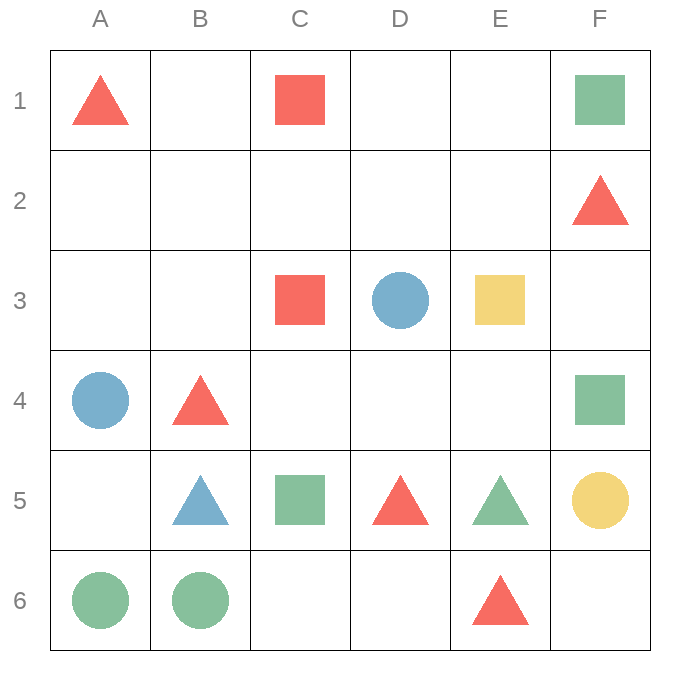

In [ ]:
from IPython.display import Image, display

# train_dataset[0][1]["content"][0]["image"]
image_path = test_dataset[0]["messages"][1]["content"][0]["image"]
display(Image(filename=image_path))

In [ ]:
output = generate_text_from_sample(model, processor, test_dataset[0])
output

In [ ]:
from IPython.display import Image, display

# train_dataset[0][1]["content"][0]["image"]
image_path = test_dataset[1]["messages"][1]["content"][0]["image"]
display(Image(filename=image_path))

In [ ]:
output = generate_text_from_sample(model, processor, test_dataset[0])
output